In [2]:
%matplotlib inline
# File formats
import ROOT
import uproot, h5py, pickle
# Data manipulation
import datetime as dt
import numpy as np
import pandas as pd
# Plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
# Others
from tqdm.notebook import tqdm
import sys, importlib
from importlib import reload
from pathlib import Path
# Personal
import hepkit.hepData as hd
import hepkit.hepIO as hio
import hepkit.hepPlot as hp
import hepkit.hepFormat as hf
# Colors
mc = [
    [35/255,55/255,59/255],
    [237/255,138/255,46/255],
    [131/255,40/255,0/255],
    [0/255,123/255,68/255],
    [107/255,60/255,79/255],
    [118/255,93/255,68/255],
    [62/255,79/255,51/255],
    [147/255,161/255,161/255]
]


# Add current directory to import path and import locals
pathFromHere = Path("__file__").parent.absolute()
sys.path.insert(1, pathFromHere)
import Libraries.charge_library as cl
import Libraries.light_library as ll
import Libraries.meta_library as ml
import Libraries.evd_library as evd
import Libraries.michelCandidate_class as mic
import Libraries.betheBloch_library as bbl

hf.DefaultSetup()

Welcome to JupyROOT 6.22/08


In [3]:
%%time
reload(cl)
reload(ll)

### FILENAMES
cpath = '/home/dporzio/Data/Michel/michel_datalog_2021_04_04_16_19_13_CEST_evd.h5'
ldir = '/home/dporzio/Data/Michel'

### LOAD LIGHT DATA
# Uproot
ldata, lpath = ml.FindPartnerLightFile(cpath,ldir)
# Root
rfile = ROOT.TFile.Open(lpath, 'read')
rwf = rfile.Get('rwf')
# Convert utime to a better usable format
ldata['utime_ms'] = ldata['utime_ms'].astype(np.int64)

### LOAD CHARGE DATA
cdata = h5py.File(cpath,'r')

h_events = cdata['events']
h_trigs = cdata['ext_trigs']
h_tracks = cdata['tracks']
h_hits = cdata['hits']
h_info = cdata['info'].attrs

print("events:",[t for t in cdata['events'].dtype.names])
print("tracks:",[t for t in cdata['tracks'].dtype.names])
print("hits:",[t for t in cdata['hits'].dtype.names])
print("ext_trigs:",[t for t in cdata['ext_trigs'].dtype.names])
print("info:",[t for t in (cdata['info'].attrs).keys()])

### LOAD GEOMETRY DATA
geometryHelper = cl.GetGeometryHelper(h_info)

# LOAD GOOD MICHELS
filename = '/home/dporzio/App/MichelElectrons_Analysis/Database_GoodMichels/goodMichels.pkl'
df = pickle.load(open(filename,'rb'))

def GetOrientation(start,end):
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    dz = end[2] - start[2]
    theta = np.arctan2(np.linalg.norm([dx,dy]),dz)
    phi = np.arctan2(dy,dx)
    return [dx,dy,dz], theta, phi

def EuDistance(p1,p2):
    return np.sqrt(np.power(p1[0]-p2[0],2.) + np.power(p1[1]-p2[1],2.) + np.power(p1[2]-p2[2],2.))

### Last time I forgot to assign timing information to the Michels so we have to do it again here
evids = df['id_eventId']
datime, offset = [], []
# for evid in evids:

Charge file 2021_04_04_16_19_13 has been matched to light file ['20210404_161914.data'].
events: ['evid', 'track_ref', 'hit_ref', 'nhit', 'q', 'ts_start', 'ts_end', 'ntracks', 'ext_trig_ref', 'n_ext_trigs', 'unix_ts', 'q_raw']
tracks: ['track_id', 'event_ref', 'hit_ref', 'theta', 't0', 'phi', 'xp', 'yp', 'nhit', 'q', 'ts_start', 'ts_end', 'residual', 'length', 'start', 'end', 'q_raw', 't0_type']
hits: ['hid', 'px', 'py', 'ts', 'q', 'iochannel', 'iogroup', 'chipid', 'channelid', 'geom', 'event_ref', 'q_raw']
ext_trigs: ['trig_id', 'event_ref', 'ts', 'type']
info: ['clock_period', 'configuration_file', 'electron_lifetime_file', 'geometry_file', 'pedestal_file', 'source_file', 'vdrift']
CPU times: user 4.63 s, sys: 655 ms, total: 5.28 s
Wall time: 5.27 s


In [5]:
reload(bbl)
conversionFactor = 245 # #e-/mv, q is in mv, which corresponds to 245 electrons

trackAnaRange = len(df)
# trackAnaRange = 10

x,y,t = [],[],[]

michelEnergy_v = []
for g in tqdm(range(trackAnaRange)):
    michelCand = df.iloc[g]
    michelTrackId = michelCand['e_id_trackId'][0]
    michelTrack = h_tracks[michelTrackId]
    michelHitsId = michelTrack['hit_ref']
    michelHits = h_hits[michelHitsId]
    michelCharge = michelHits['q'].sum()
    michelEnergy = bbl.ConvertQtoE(michelCharge,model='box')
    michelEnergy = (michelCharge *245 * 23.6 / 0.67)/1e6
    michelEnergy_v.append(michelEnergy)
#     if michelEnergy>120:
#         print(michelTrackId,michelEnergy)
#         print(len(michelHits['px']))
#         x = michelHits['px']
#         y = michelHits['py']
#         t = michelHits['ts']

  0%|          | 0/430 [00:00<?, ?it/s]

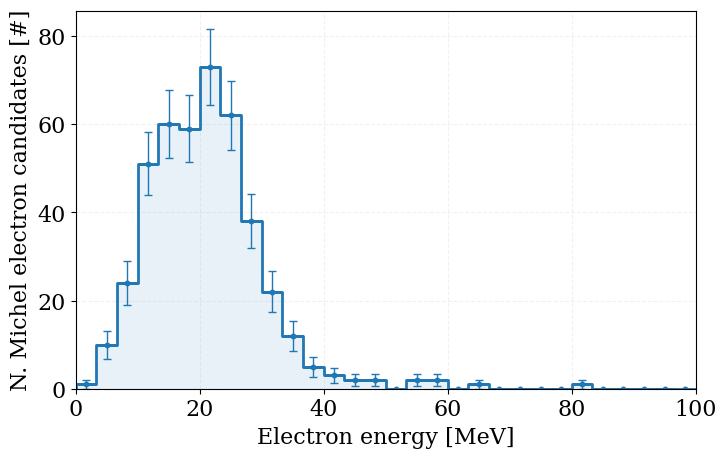

In [6]:
nbins = 30
xlims = [0,100]

plt.figure(figsize=(8,5),facecolor='white',dpi=100)
hp.HepHist(michelEnergy_v,nbins=nbins,xlims=xlims,color='C0',label='Michel electrons')
plt.xlabel('Electron energy [MeV]')
plt.ylabel('N. Michel electron candidates [#]')
plt.grid(True,ls='--',color='C7',alpha=0.1)
plt.xlim(0,100)
# plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0, frameon=False)
plt.savefig('michel_spectrum.pdf',bbox_inches='tight', pad_inches=0.3)
plt.show()

In [12]:
import random
import string

def randompassword():
    random_source = string.ascii_letters + string.digits + string.punctuation
    password_component = random.choice(string.ascii_lowercase)
    password_component += random.choice(string.ascii_uppercase)
    password_component += random.choice(string.ascii_uppercase)
    password_component += random.choice(string.digits)
    password_component += random.choice(string.punctuation)
    
    for i in range(10):
        password_component += random.choice(random_source)
    
    password_list = list(password_component)
    random.SystemRandom().shuffle(password_list)
    password_component = ''.join(password_list)
    return password_component
    

print(randompassword())


6vmqZZ0)Q)-_x-2
